### If you want to include tabpfn model

In [1]:
!pip install /kaggle/input/tabpfn/tabpfn/tabpfn-0.1.9-py3-none-any.whl
!mkdir /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/tabpfn/tabpfn/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/


#see this: https://www.kaggle.com/datasets/carlmcbrideellis/tabpfn-019-whl

Processing /kaggle/input/tabpfn/tabpfn/tabpfn-0.1.9-py3-none-any.whl


# Preparation
This version consider only train and test set and does not include greeks. For inclusion of greeks meta_data please see: intro_to_solution_2_with_greeks notebook

In [2]:
import pandas as pd
import numpy as np

# Load datasets Kaggle
train_0 = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test_0 = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks_0 = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')


# Save 'Id' columns
train_id = train_0['Id']
test_id = test_0['Id']
train_class = train_0["Class"]

# Handling categorical feature EJ: get_dummies
train_base = pd.get_dummies(train_0, columns=['EJ'], prefix='EJ')
test_base = pd.get_dummies(test_0, columns=['EJ'], prefix='EJ')
test_base['EJ_B'] = 0


"""
# Preprocessing for greeks.csv
#greeks = pd.get_dummies(greeks, columns=['Alpha'], prefix='Alpha')
greeks = pd.get_dummies(greeks, columns=['Beta'], prefix='Beta')
greeks = pd.get_dummies(greeks, columns=['Gamma'], prefix='Gamma')
greeks = pd.get_dummies(greeks, columns=['Delta'], prefix='Delta')

greeks['Epsilon'] = pd.to_datetime(greeks['Epsilon'], errors='coerce')

# Extract features from date
greeks['Year'] = greeks['Epsilon'].dt.year

# Now drop 'Epsilon'
greeks.drop('Epsilon', axis=1, inplace=True)
"""

train_base = train_base.drop("Id", axis=1)
train_base = train_base.drop("Class", axis=1)
test_base = test_base.drop("Id", axis=1)
y_base = train_class



## Handling outliers using interquartile range (IQR)

In [3]:
features = train_base.columns
train_outliers = train_base.copy()
test_outliers = test_base.copy()

outlier_threshold = 1.5

for feature in features:
    # Calculate the quartiles
    q1 = np.percentile(train_outliers[feature].values.astype(float), 25)
    q3 = np.percentile(train_outliers[feature].values.astype(float), 75)
    
    # Calculate the IQR
    iqr = q3 - q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = q1 - outlier_threshold * iqr
    upper_bound = q3 + outlier_threshold * iqr
    
    # Identify outliers based on the threshold
    outliers = train_outliers[(train_outliers[feature] < lower_bound) | (train_outliers[feature] > upper_bound)]
    
    # Convert outliers to NaN values
    train_outliers.loc[outliers.index, feature] = np.nan
    
for feature in features:
    # Calculate the quartiles
    q1 = np.percentile(test_outliers[feature].values.astype(float), 25)
    q3 = np.percentile(test_outliers[feature].values.astype(float), 75)
    
    # Calculate the IQR
    iqr = q3 - q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = q1 - outlier_threshold * iqr
    upper_bound = q3 + outlier_threshold * iqr
    
    # Identify outliers based on the threshold
    outliers = test_outliers[(test_outliers[feature] < lower_bound) | (test_outliers[feature] > upper_bound)]
    
    # Convert outliers to NaN values
    test_outliers.loc[outliers.index, feature] = np.nan


## Handling missing values using KNN and handling imbalance Class using SMOTE or RUS
Although scaling is not necessary for tree-base models, since knn is a distance-base model scaling is necessary then for adopting knn for missing values

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Standardize the train and test data
scaler = StandardScaler()
train_sc = scaler.fit_transform(train_outliers)
test_sc = scaler.transform(test_outliers)


# Handling missing values in train and test using a KNNImputer
imputer = KNNImputer(n_neighbors=10, weights='distance')
train_sc_knn = pd.DataFrame(imputer.fit_transform(train_sc), columns=train_base.columns)
test_sc_knn = pd.DataFrame(imputer.fit_transform(test_sc), columns=test_base.columns)

# SMOTE Oversampling
sm = SMOTE(sampling_strategy=0.95, random_state=42, k_neighbors=50)
train_sc_knn_sm, y_sm = sm.fit_resample(train_sc_knn, y_base)
train_sc_knn_sm = pd.DataFrame(train_sc_knn_sm, columns = train_base.columns)

# or # RandomUndersampling
#rus = RandomUnderSampler(sampling_strategy=0.95, random_state=42)
#train_sc_knn_rus, y_rus = rus.fit_resample(train_sc_knn, y_base)
#train_sc_knn_rus = pd.DataFrame(train_sc_knn_rus, columns=train_base.columns)

#train_sks : scale, knn, SMOTE
train_sks = train_sc_knn_sm.copy()
test_sks = test_sc_knn.copy()
y_sks = y_sm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Individual Models

Now let's try a couple of different models to get a base line for our classification

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc,log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from tabpfn import TabPFNClassifier



# Define the base models
logreg = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='lbfgs',
    max_iter=100,
    random_state=42
)

svm = SVC(
    kernel='rbf',
    C=2.0,
    gamma='scale',
    probability=True, 
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

xgb = XGBClassifier(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='logloss',
    booster='gbtree',
    random_state=42
)

catb = CatBoostClassifier(verbose=0, iterations=300, depth=6, learning_rate=0.1, loss_function='Logloss', random_seed=42)


mlpc = MLPClassifier(
    hidden_layer_sizes=(300, 600, 100),
    activation= "relu",
    solver='adam',
    random_state=42,
    alpha = 0.01
)


tabpfn_classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=65)


def plot_learning_curve(models, model_names, X, y, cv=5,scoring='neg_log_loss' ):
    plt.figure(figsize=(12, 8))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'brown', 'y']
    markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'X']

    for i, model in enumerate(models):
        train_sizes, train_scores, validation_scores = learning_curve(
            estimator=model,
            X=X,
            y=y,
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=cv,
            scoring=scoring
        )

        # Calculate mean and standard deviation for train and validation sets
        train_scores_mean = -np.mean(train_scores, axis=1)
        validation_scores_mean = -np.mean(validation_scores, axis=1)

        # Plot the learning curves
        plt.plot(train_sizes, train_scores_mean, marker=markers[i], color=colors[i],
                 label=model_names[i] + " Training score", linestyle='--')
        plt.plot(train_sizes, validation_scores_mean, marker=markers[i], color=colors[i],
                 label=model_names[i] + " Cross-validation score")

   
    plt.title('Learning Curves')
    plt.xlabel(f"{scoring}")
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def calculate_metrics(models, model_names, X_train, y_train, X_val, y_val):

    for model,model_name in zip(models,model_names):
        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        train_pred = model.predict(X_train)
        train_pred_prob = model.predict_proba(X_train)[:, 1]
        val_pred = model.predict(X_val)
        val_pred_prob = model.predict_proba(X_val)[:, 1]
        
        precision_train, recall_train, _ = precision_recall_curve(y_train, train_pred_prob)
        precision_val, recall_val, _ = precision_recall_curve(y_val, val_pred_prob)
        
        df_metrics = pd.DataFrame(
            [["Training",
              log_loss(y_train, train_pred_prob),
              accuracy_score(y_train, train_pred),
              precision_score(y_train, train_pred),
              recall_score(y_train, train_pred),
              f1_score(y_train, train_pred),
              roc_auc_score(y_train, train_pred),
              auc(recall_train, precision_train)
             ],
            ["Validation",
              log_loss(y_val, val_pred_prob),
              accuracy_score(y_val, val_pred),
              precision_score(y_val, val_pred),
              recall_score(y_val, val_pred),
              f1_score(y_val, val_pred),
              roc_auc_score(y_val, val_pred),
              auc(recall_val, precision_val)
             ]],
            columns=["", "Log Loss", "Accuracy", "Precision", "Recall", "F1", "AUC-ROC", "AUC-PRC"]
        )
        
        print(f"Metrics for model {model_name}\n")
        display(df_metrics)
        print("\n")
        
    for model,model_name in zip(models,model_names):
        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        train_pred = model.predict(X_train)
        train_pred_prob = model.predict_proba(X_train)[:, 1]
        val_pred = model.predict(X_val)
        val_pred_prob = model.predict_proba(X_val)[:, 1]
        
        precision_train, recall_train, _ = precision_recall_curve(y_train, train_pred_prob)
        precision_val, recall_val, _ = precision_recall_curve(y_val, val_pred_prob)
        print(f"\nConfusion Matrix for model {model_name}\n")
        
        # Plot confusion matrices
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        sns.heatmap(confusion_matrix(y_train, train_pred), annot=True, fmt='d', ax=axes[0])
        axes[0].set_title('Train Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')
        
        sns.heatmap(confusion_matrix(y_val, val_pred), annot=True, fmt='d', ax=axes[1])
        axes[1].set_title('Validation Confusion Matrix')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('True')
        
        plt.tight_layout()
        plt.show()
        print("\n---------------------------------------\n")


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [6]:
# Set up train and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    train_sks, y_sks,
    test_size=0.3, stratify=y_sks, random_state=42
)

In [7]:
models = [logreg, svm, mlpc, rf, xgb, catb,tabpfn_classifier]
model_names = ['LogisticRegression','SVM','MLPC'  ,'Random Forest', 'XGBClassifier', 'CatBoostClassifier','tabpfn_classifier']


scoring_metrics = [
    'accuracy',
    'roc_auc',
    'balanced_accuracy',
    'average_precision',
    'neg_log_loss',
    'neg_brier_score',
    'f1',
    'precision',
    'recall',
    'jaccard'
]

# Evalutation

Metrics for model LogisticRegression



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.249771,0.904899,0.897661,0.908284,0.902941,0.904985,0.954831
1,Validation,0.334008,0.862416,0.829114,0.903448,0.864686,0.863489,0.925110




Metrics for model SVM



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.004642,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Validation,0.058367,0.973154,0.953642,0.993103,0.972973,0.973676,0.998642




Metrics for model MLPC



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.000247,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Validation,0.148191,0.956376,0.928571,0.986207,0.956522,0.957156,0.991366




Metrics for model Random Forest



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.064063,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Validation,0.231503,0.95302,0.933775,0.972414,0.952703,0.953527,0.979401




Metrics for model XGBClassifier



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.030370,1.000000,1.000000,1.00000,1.000000,1.0000,1.000000
1,Validation,0.177681,0.932886,0.893082,0.97931,0.934211,0.9341,0.983345




Metrics for model CatBoostClassifier



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.002132,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
1,Validation,0.133321,0.946309,0.916129,0.97931,0.946667,0.947172,0.993688




Metrics for model tabpfn_classifier



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.006184,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Validation,0.073094,0.966443,0.959184,0.972414,0.965753,0.966599,0.998115





Confusion Matrix for model LogisticRegression



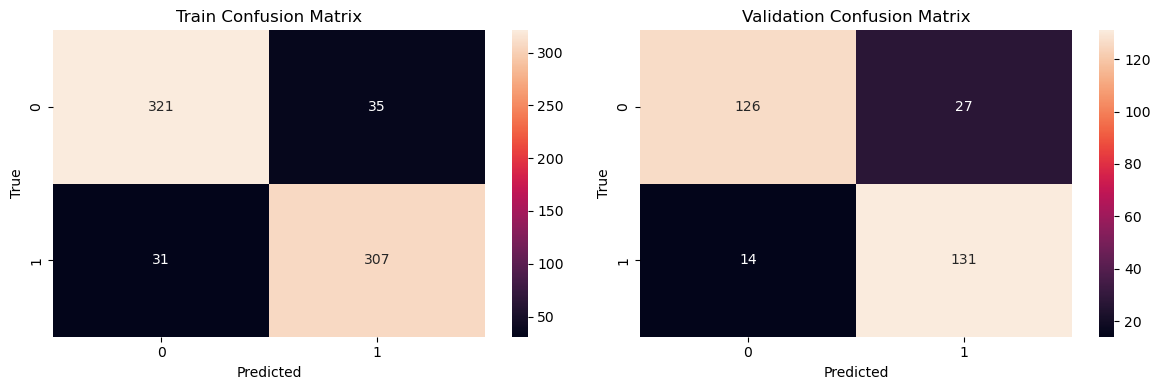


---------------------------------------


Confusion Matrix for model SVM



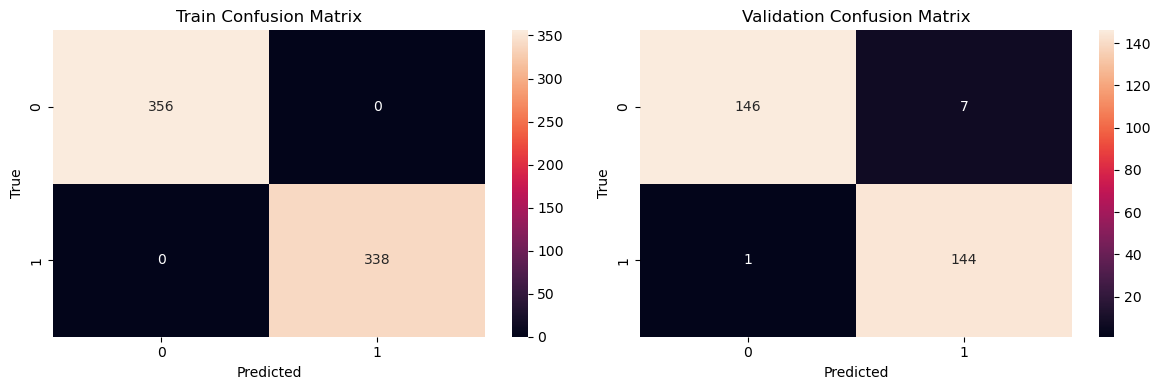


---------------------------------------


Confusion Matrix for model MLPC



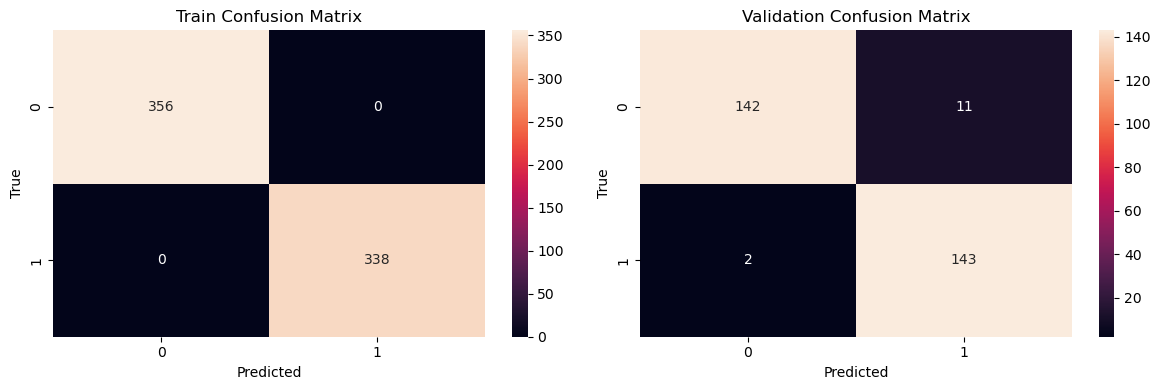


---------------------------------------


Confusion Matrix for model Random Forest



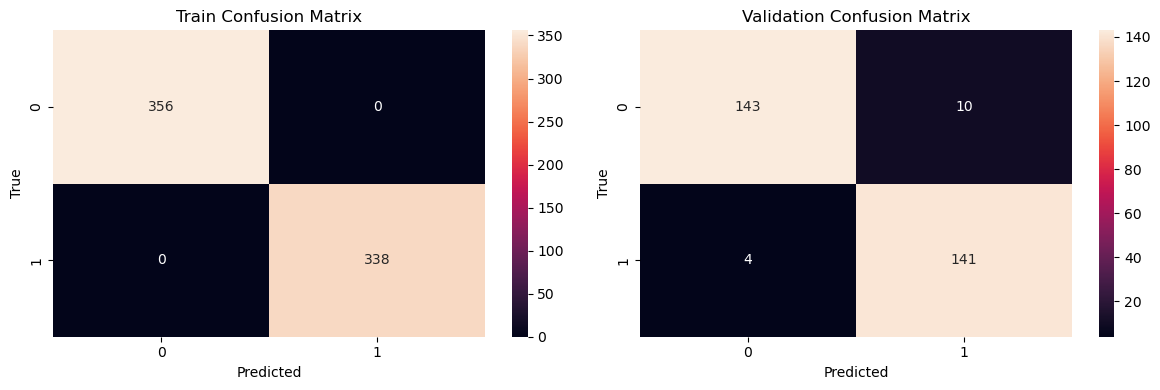


---------------------------------------


Confusion Matrix for model XGBClassifier



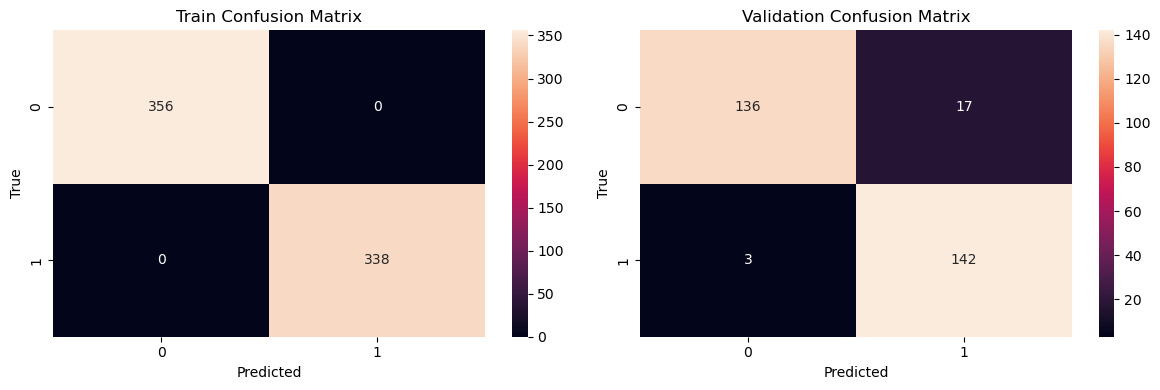


---------------------------------------


Confusion Matrix for model CatBoostClassifier



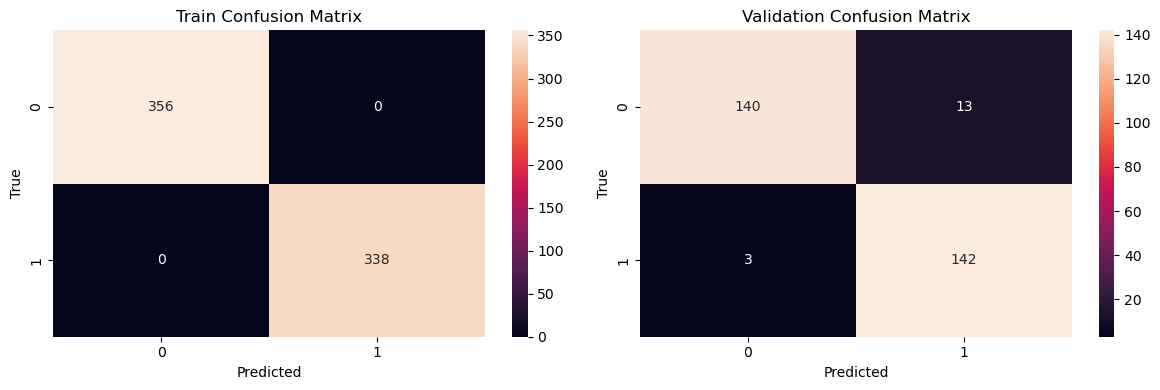


---------------------------------------


Confusion Matrix for model tabpfn_classifier



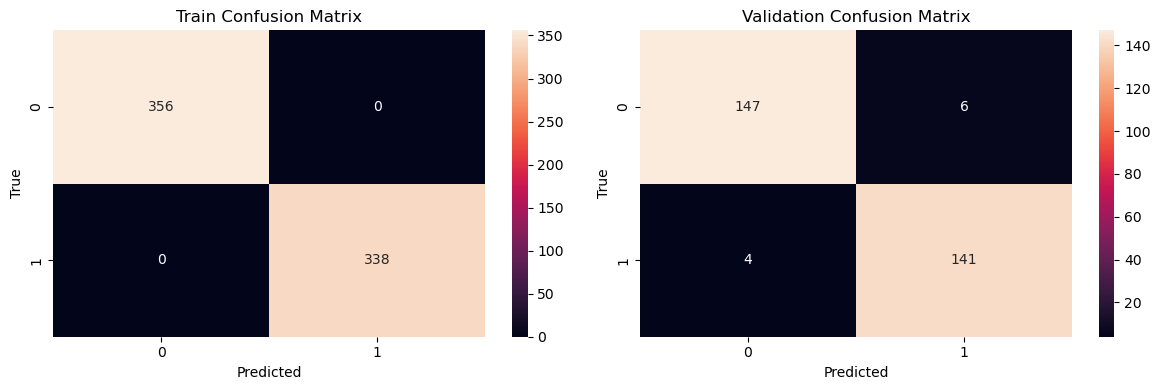


---------------------------------------



In [8]:
# scoring_metrics and confusion matrix for each model
calculate_metrics(models, model_names, X_train, y_train, X_val, y_val)

precision (TP/TP+FP): rate of misclassifying negative instances as positive. 
recall (TP/TP+FN): rate of misclassifying positive instances as negative.

In our case precision is lower than recall in all the models, means misclassifying negative instances (0) as positive (1) are more frequent than misclassifying positive instances (1) as negative (0), i.e., we have more false class1 in comparison to number of false class0.

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Tr

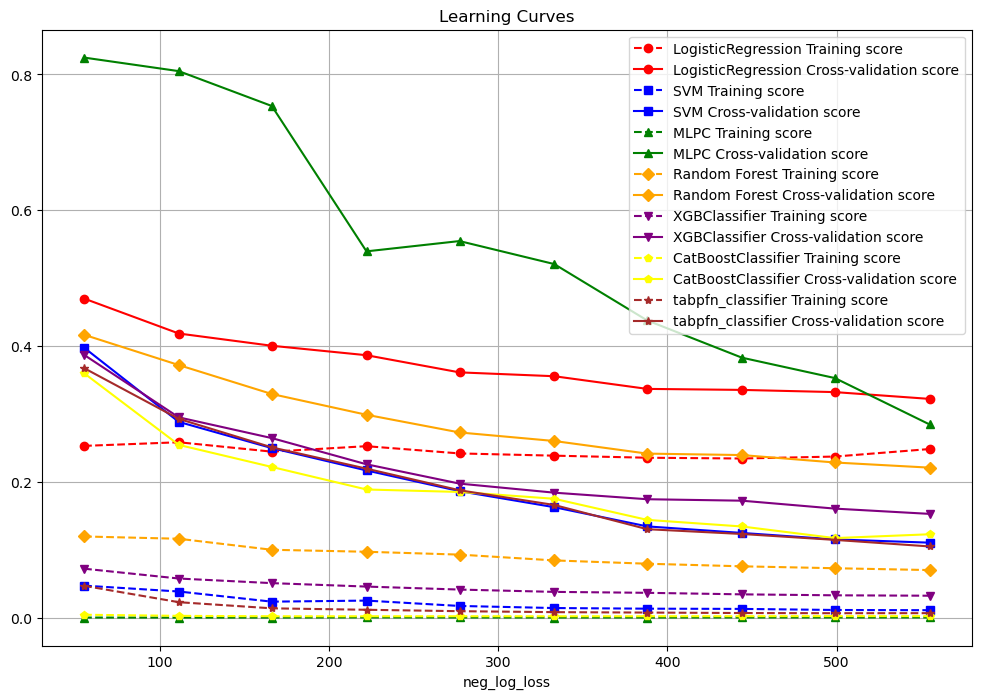

In [9]:
# Plot the learning curve for each model
plot_learning_curve(models, model_names, X_train, y_train, cv=5, scoring = "neg_log_loss")

In [10]:
#you might want to plot the models for other scoring metrics as well
"""for score in scoring_metrics:
    plot_learning_curve(models, model_names, X_train, y_train, cv=5, scoring = score)"""

'for score in scoring_metrics:\n    plot_learning_curve(models, model_names, X_train, y_train, cv=5, scoring = score)'

# Ensemble Model

In [11]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[('xgboost', xgb), ('svm', svm), ('MLPC', mlpc), ('rf', rf), 
               ('catboost', catb), ("tabpfn",tabpfn_classifier)],
    voting='soft',
    weights=[1, 2, 2, 1, 2, 3]
)

# Ensemble Model

In [12]:
models = [svm, mlpc, rf, xgb, catb, tabpfn_classifier, ensemble_model]
model_names = ['SVM','MLPC'  ,'Random Forest', 'XGBClassifier', 'CatBoostClassifier','tabpfn_classifier',"Ensemble Model"]


# Evaluation of Ensemble Model

Metrics for model SVM



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.004642,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Validation,0.058367,0.973154,0.953642,0.993103,0.972973,0.973676,0.998642




Metrics for model MLPC



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.000247,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Validation,0.148191,0.956376,0.928571,0.986207,0.956522,0.957156,0.991366




Metrics for model Random Forest



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.064063,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Validation,0.231503,0.95302,0.933775,0.972414,0.952703,0.953527,0.979401




Metrics for model XGBClassifier



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.030370,1.000000,1.000000,1.00000,1.000000,1.0000,1.000000
1,Validation,0.177681,0.932886,0.893082,0.97931,0.934211,0.9341,0.983345




Metrics for model CatBoostClassifier



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.002132,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
1,Validation,0.133321,0.946309,0.916129,0.97931,0.946667,0.947172,0.993688




Metrics for model tabpfn_classifier



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.006184,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Validation,0.073094,0.966443,0.959184,0.972414,0.965753,0.966599,0.998115




Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Metrics for model Ensemble Model



,,Log Loss,Accuracy,Precision,Recall,F1,AUC-ROC,AUC-PRC
0,Training,0.011187,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
1,Validation,0.088108,0.969799,0.953333,0.986207,0.969492,0.970228,0.99818





Confusion Matrix for model SVM



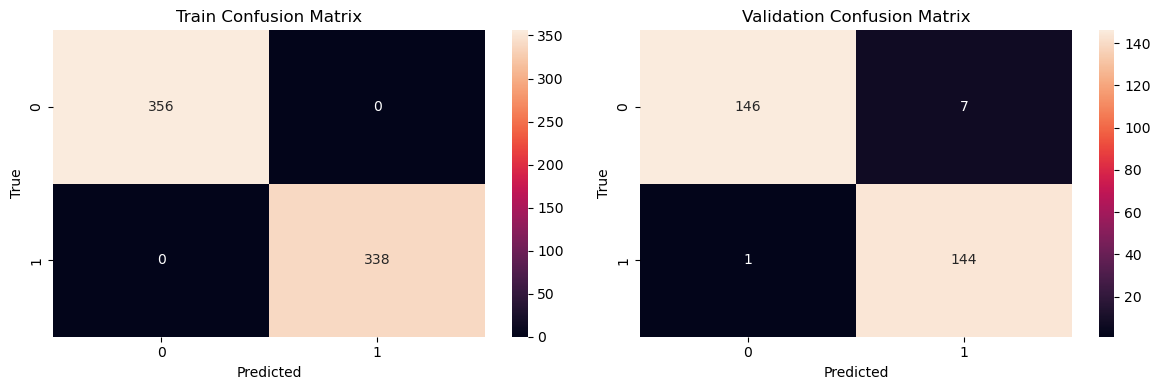


---------------------------------------


Confusion Matrix for model MLPC



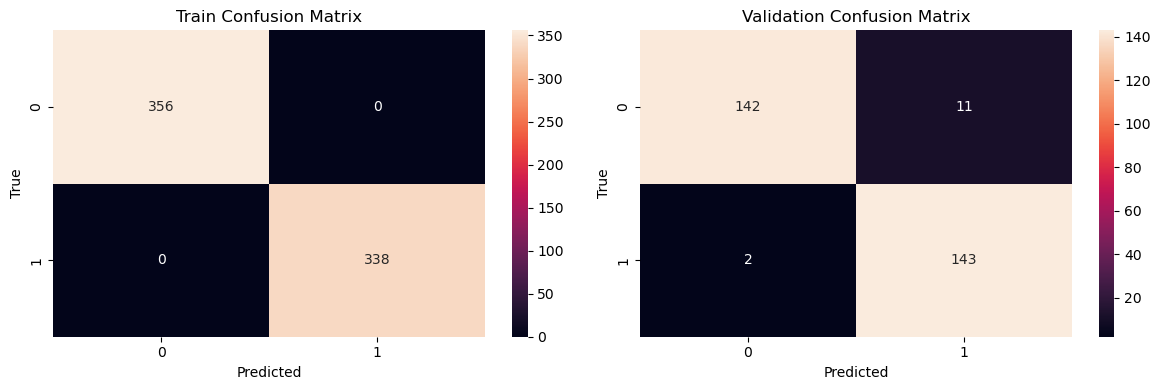


---------------------------------------


Confusion Matrix for model Random Forest



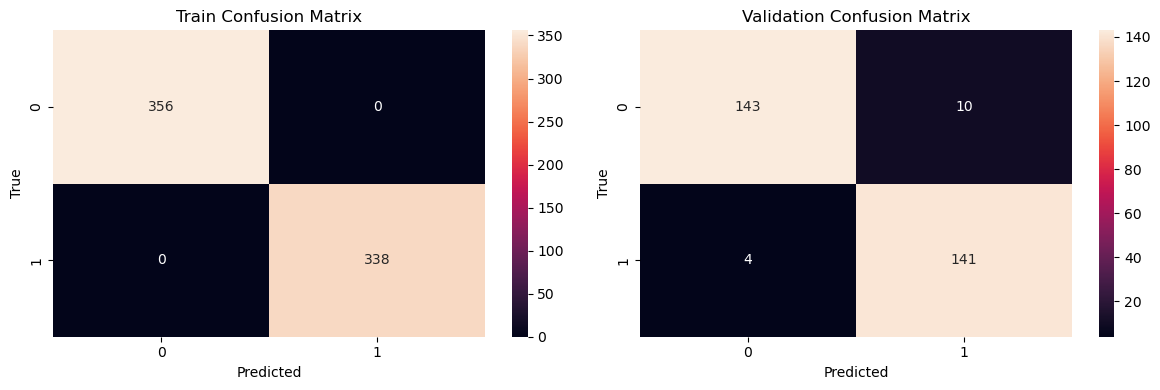


---------------------------------------


Confusion Matrix for model XGBClassifier



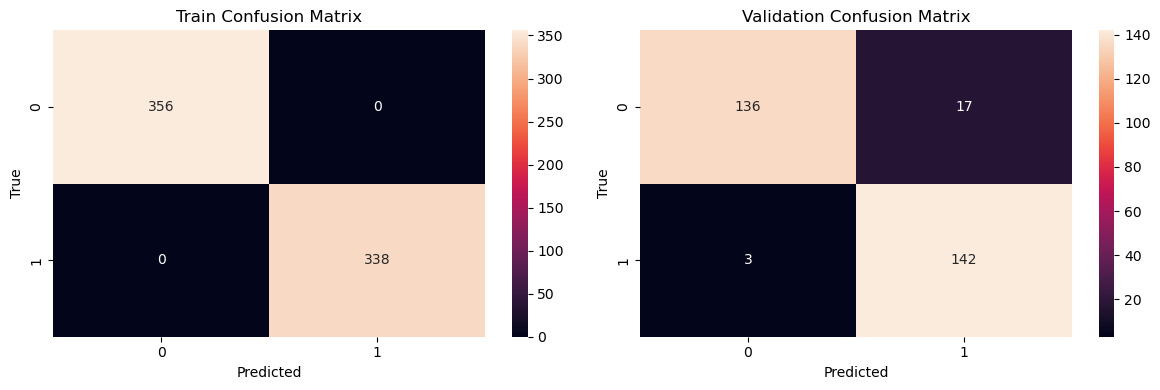


---------------------------------------


Confusion Matrix for model CatBoostClassifier



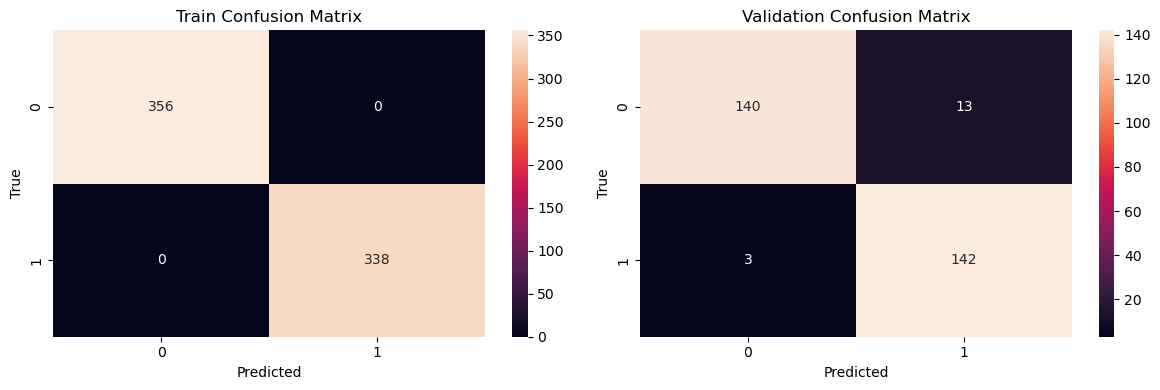


---------------------------------------


Confusion Matrix for model tabpfn_classifier



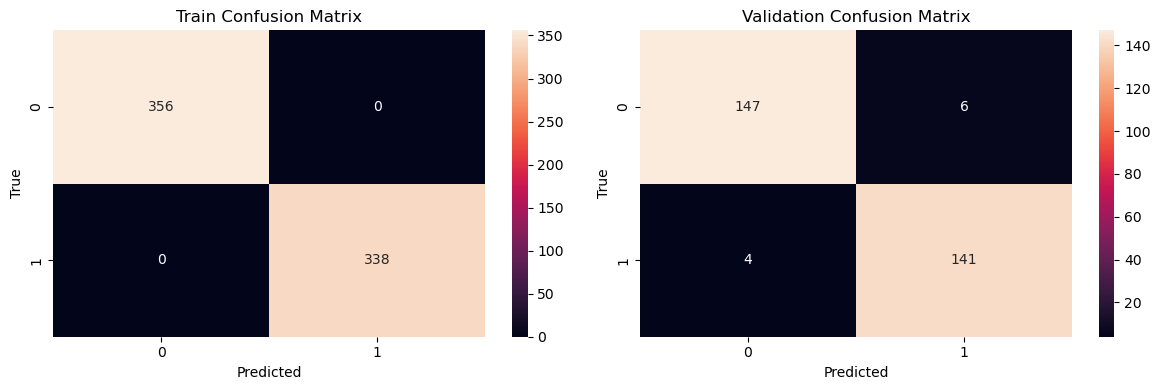


---------------------------------------

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Confusion Matrix for model Ensemble Model



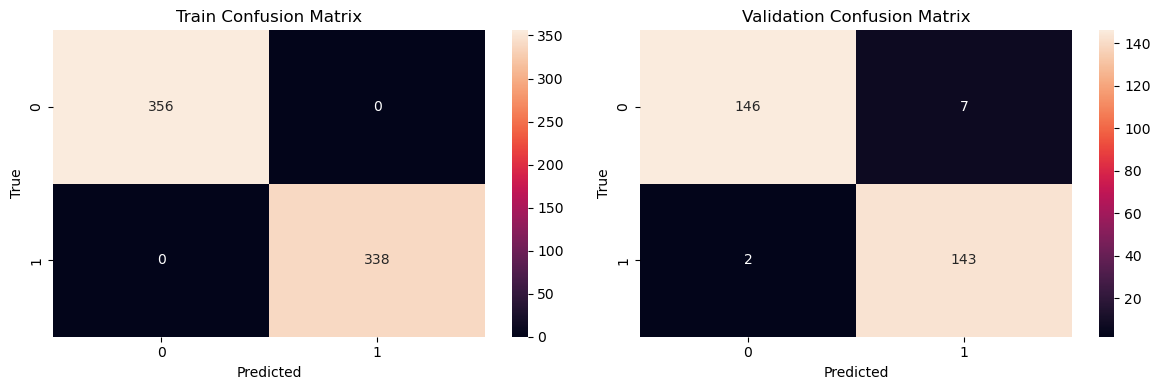


---------------------------------------



In [13]:
# scoring_metrics and confusion matrix for each model
calculate_metrics(models, model_names, X_train, y_train, X_val, y_val)

# Submit

In [14]:
X_test = test_sks.copy()
# Make predictions on the final test set
final_probs = ensemble_model.predict_proba(X_test)

submission = pd.DataFrame({
    "Id": test_id,
    "class_0": final_probs[:, 0],  
    "class_1": final_probs[:, 1] 
})


submission.to_csv("submission.csv", index=False)

In [15]:
submission

,Id,class_0,class_1
0,00eed32682bb,0.953771,0.046229
1,010ebe33f668,0.953771,0.046229
2,02fa521e1838,0.953771,0.046229
3,040e15f562a2,0.953771,0.046229
4,046e85c7cc7f,0.953771,0.046229
